<a href="https://colab.research.google.com/github/qnrua0511/kaggle_study/blob/main/New_York_City_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [뉴욕 택시 요금 예측](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction)

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

100% 1.56G/1.56G [00:19<00:00, 106MB/s] 
100% 1.56G/1.56G [00:19<00:00, 84.3MB/s]


In [5]:
!unzip new-york-city-taxi-fare-prediction.zip

Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import os

def convert_bytes(file_path,unit=None):
  size=os.path.getsize(file_path)
  if unit=="KB":
    return print('File size: '+str(round(size/1024,3))+'Kilobytes')
  elif unit=='MB':
    return print('File size: '+str(round(size/(1024*1024),3))+'Megabytes')
  elif unit=='GB':
    return print('File size: '+str(round(size/(1024**3),3))+'Gigabytes')
  else:
    return print('File size: '+str(size)+'bytes')

file_path='train.csv'
convert_bytes(file_path)
convert_bytes(file_path,'GB')

File size: 5697178298bytes
File size: 5.306Gigabytes


## 데이터 시각화

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
def skip_logic(index,skip_num):
  if index%skip_num==0:
    return False
  return True

train=pd.read_csv('./train.csv',skiprows=lambda x: skip_logic(x,4), parse_dates=["pickup_datetime"])
print(train.shape)
test=pd.read_csv('./test.csv')
submission=pd.read_csv('./sample_submission.csv')

(13855964, 8)


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13855964 entries, 0 to 13855963
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 845.7+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                9914 non-null   object 
 1   pickup_datetime    9914 non-null   object 
 2   pickup_longitude   9914 non-null   float64
 3   pickup_latitude    9914 non-null   float64
 4   dropoff_longitude  9914 non-null   float64
 5   dropoff_latitude   9914 non-null   float64
 6   passenger_count    9914 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 542.3+ KB


test 데이터는 fare_amount가 없어 종속변수로 추정할 수 있음

 변수 설명
 - Key: 일반적으로 Key는 각 행을 구별하는 고유한 문자열
 - Pickup_Datetime: 택시 승차 시 시간
 - Pickup_Longitude: 택시 승차 시 경도
 - Pickup_Latitude: 택시 승차 시 위도
 - Dropoff_Longitude: 택시 하차 시 경도
 - Dropoff_Latitude: 택시 하차 시 위도
 - Passenger_Count: 택시 승객 수
 - Fare_Amount: 택시 요금($)


In [11]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
1,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00+00:00,-73.951300,40.774138,-73.990095,40.751048,1
2,2012-12-24 11:24:00.00000098,5.5,2012-12-24 11:24:00+00:00,0.000000,0.000000,0.000000,0.000000,3
3,2013-11-23 12:57:00.000000190,5.0,2013-11-23 12:57:00+00:00,0.000000,0.000000,0.000000,0.000000,1
4,2014-12-06 20:36:22.0000008,4.0,2014-12-06 20:36:22+00:00,-73.979815,40.751902,-73.979446,40.755481,1


In [12]:
print("Minimum Value of train:",train['fare_amount'].min())
print("Maximum Value of train:",train['fare_amount'].max())

Minimum Value of train: -300.0
Maximum Value of train: 93963.36


금액이 음수란 것은 해석하기 어렵기에 가급적이면 삭제하는 것이 좋음

In [13]:
#음수 개수 확인
print("Fare Amount<0:",sum(train['fare_amount']<0))
print("Fare Amount>0:",sum(train['fare_amount']>0))

Fare Amount<0: 610
Fare Amount>0: 13855007


In [14]:
from collections import Counter
Counter(train['fare_amount']<0)

Counter({False: 13855354, True: 610})

In [15]:
train=train.drop(train[train['fare_amount']<0].index,axis=0).reset_index(drop=True)
Counter(train['fare_amount']<0)

Counter({False: 13855354})

극단적인 데이터는 제거하기 위해 500달러 이상의 개수를 확인 후 제거함

In [16]:
Counter(train['fare_amount']>500)

Counter({False: 13855348, True: 6})

In [17]:
train=train.drop(train[train['fare_amount']>500].index,axis=0).reset_index(drop=True)
print("Minimum Value of train:",train['fare_amount'].min())
print("Maximum Value of train:",train['fare_amount'].max())

Minimum Value of train: 0.0
Maximum Value of train: 500.0


데이터가 너무 많아 시각화 하기에 어려움(메모리 소비가 너무 큼)

데이터의 크기를 줄이기 위해 샘플링을 하는데, 이 때 주로 쓰이는 것이 층화 추출 샘플링임

In [18]:
train['passenger_count'].unique()

array([  1,   3,   6,   2,   5,   4,   0, 208, 129,  51,   8,   9])

0명에서 비용이 나오는 것과 208,129,51은 택시에 한번에 탈 수 있는 승객이 아니기에 전산오류라고 판단
- 6보다 큰 데이터는 삭제하기로 판단

In [19]:
train=train.drop(train[train['passenger_count']>6].index,axis=0).reset_index(drop=True)
train['passenger_count'].unique()

array([1, 3, 6, 2, 5, 4, 0])

In [20]:
train=train.drop(train[train['passenger_count']==0].index,axis=0).reset_index(drop=True)
train['passenger_count'].unique()

array([1, 3, 6, 2, 5, 4])

In [21]:
#passenger_count의 비율확인
train['passenger_count'].value_counts(normalize=True)

,proportion
passenger_count,
1,0.693959
2,0.148144
5,0.071225
3,0.044029
4,0.021383
6,0.021260


1명 탑승한 택시 승객의 비율이 약 70%에 해당하는 것을 확인할 수 있음

In [22]:
#예제
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit #층화추출

sample=pd.DataFrame({'group':np.repeat(['A','B','C'],(60,40,20)),
                     'sample_value':np.random.randn(120)})

split=StratifiedShuffleSplit(n_splits=1,test_size=0.7,random_state=42)

for train_index, test_index in split.split(sample,sample['group']):
  strata_train_set=sample.loc[train_index]
  test_set=sample.loc[test_index]

print(sample['group'].value_counts(normalize=True))
print(sample.shape)
print(strata_train_set['group'].value_counts(normalize=True))
print(strata_train_set.shape)

group
A    0.500000
B    0.333333
C    0.166667
Name: proportion, dtype: float64
(120, 2)
group
A    0.500000
B    0.333333
C    0.166667
Name: proportion, dtype: float64
(36, 2)


In [23]:
split=StratifiedShuffleSplit(n_splits=1,test_size=0.001,random_state=42)

for large_index, sample_index in split.split(train, train['passenger_count']):
  large_df=train.loc[large_index]
  sample_df=train.loc[sample_index]

print("train:\n", train['passenger_count'].value_counts(normalize=True),train.shape)
print("sample:\n",sample_df['passenger_count'].value_counts(normalize=True),sample_df.shape)

train:
 passenger_count
1    0.693959
2    0.148144
5    0.071225
3    0.044029
4    0.021383
6    0.021260
Name: proportion, dtype: float64 (13806160, 8)
sample:
 passenger_count
1    0.693996
2    0.148113
5    0.071196
3    0.044036
4    0.021366
6    0.021294
Name: proportion, dtype: float64 (13807, 8)


데이터의 크기는 전체 표본에서 0.1%로 줄어들지만, 비율은 그대로인 것을 확인할 수 있음

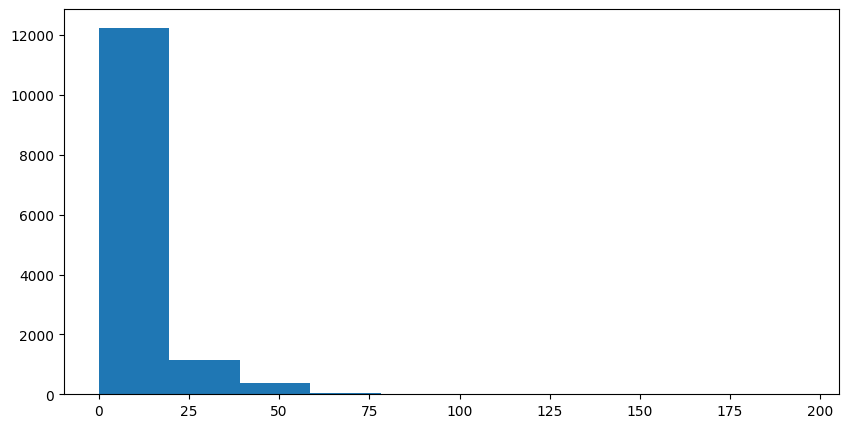

In [24]:
fig,ax=plt.subplots(figsize=(10,5))
ax.hist(sample_df['fare_amount'])
plt.show()

0~25 달러 구간이 가장 많은 비율을 보임

In [25]:
Counter(train['pickup_latitude']< -90)

Counter({False: 13806091, True: 69})

In [26]:
Counter(train['pickup_latitude']>90)

Counter({False: 13805984, True: 176})

위도는 -90~90 사이인데 범위밖의 데이터가 존재함

In [27]:
train=train.drop(train[train['pickup_latitude']< -90].index,axis=0).reset_index(drop=True)
train=train.drop(train[train['pickup_latitude']>90].index,axis=0).reset_index(drop=True)
Counter(train['pickup_latitude']>90)

Counter({False: 13805915})

경도는 -180~180 사이의 값만 존재해야함

In [28]:
train = train.drop(train[train['dropoff_latitude'] <- 90].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['dropoff_latitude'] > 90].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['pickup_longitude'] <- 180].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['pickup_longitude'] > 180].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['dropoff_longitude'] <- 180].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['dropoff_longitude'] > 180].index, axis=0).reset_index(drop=True)
train.shape

(13805499, 8)

In [29]:
train.iloc[:3,0]

,key
0,2012-04-21 04:30:42.0000001
1,2012-01-04 17:22:00.00000081
2,2012-12-24 11:24:00.00000098


In [30]:
train.iloc[:3,2]

,pickup_datetime
0,2012-04-21 04:30:42+00:00
1,2012-01-04 17:22:00+00:00
2,2012-12-24 11:24:00+00:00


In [41]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.001, random_state=42)

for large_index, sample_index in split.split(train, train['passenger_count']):
  large_df = train.loc[large_index]
  sample_df = train.loc[sample_index]

In [42]:
#차량을 탑승한 위치와 하차한 위치의 위도,경도 표시
#이상치가 존재하면 삭제하는 코드
Bounding_Box=(-74.5,-72.8,40.5,41.8)
Bounding_Box_Zoom=(-74.3,-73.7,40.5,40.9)

def select_within_boundingbox(data,BB):
  return(data.pickup_longitude>=BB[0])&(data.pickup_longitude<=BB[1])&(data.pickup_latitude>=BB[2])&(data.pickup_latitude<=BB[3])&\
   (data.dropoff_longitude>=BB[0])&(data.dropoff_longitude<=BB[1])&(data.dropoff_latitude>=BB[2])&(data.dropoff_latitude<=BB[3])

In [43]:
print('Old size: %d'%len(sample_df))
sample_df=sample_df[select_within_boundingbox(sample_df,Bounding_Box)]
print("New size: %d"%len(sample_df))

Old size: 13806
New size: 13499


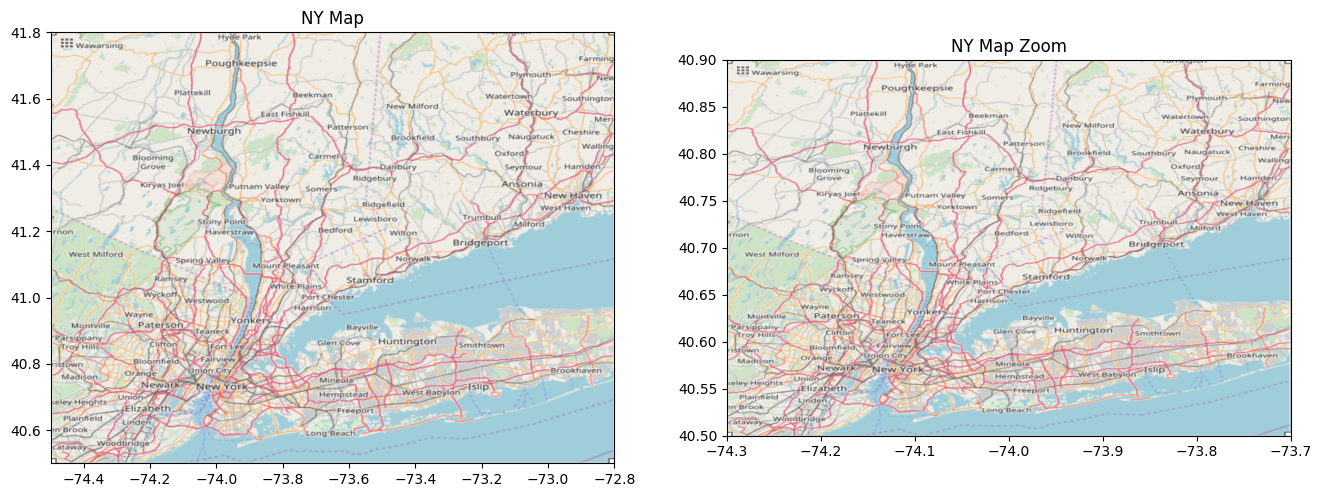

In [44]:
import ssl
from urllib.request import urlopen
from PIL import Image
import io
context=ssl._create_unverified_context()

Bounding_Box=(-74.5,-72.8,40.5,41.8)
NYC_MAP_img_path='https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png'
NYC_MAP=urlopen(NYC_MAP_img_path,context=context)
#nyc_map=plt.imread(NYC_MAP) => 안먹혀서 아래 세줄로 변경(라이브러리 추가 사용)
image_data = NYC_MAP.read()
image = Image.open(io.BytesIO(image_data))
nyc_map = np.array(image)

Bounding_Box_Zoom=(-74.3,-73.7,40.5,40.9)
NYC_MAP_ZOOM_img_path='htttps://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png'
NYC_MAP_ZOOM=urlopen(NYC_MAP_img_path,context=context)
#nyc_map_zoom=plt.imread(NYC_MAP_ZOOM) => 같은 이유로 아래 세줄로 변경
image_data_zoom = NYC_MAP_ZOOM.read()
image_zoom = Image.open(io.BytesIO(image_data_zoom))
nyc_map_zoom = np.array(image_zoom)

fig,ax=plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(nyc_map,zorder=0,extent=Bounding_Box)
ax[0].set_title("NY Map")

ax[1].imshow(nyc_map_zoom,zorder=0,extent=Bounding_Box_Zoom)
ax[1].set_title("NY Map Zoom")

plt.show()

위 지도에 산점도를 작성

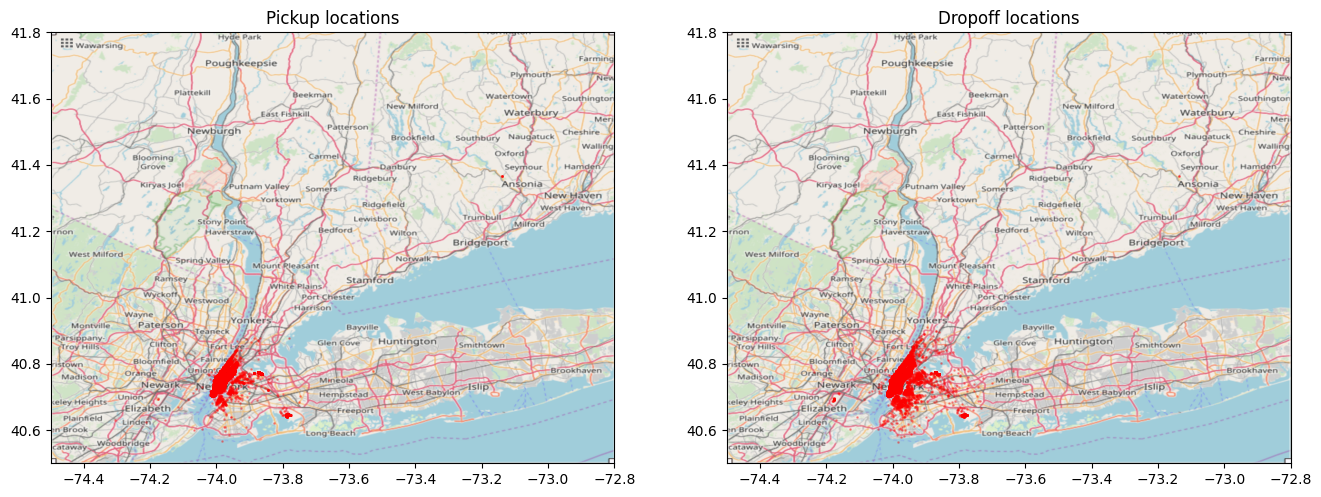

In [45]:
def scatter_plot_on_map(df,Bounding_Box,nyc_map,s=10,alpha=0.2):
  fig,axs=plt.subplots(1,2,figsize=(16,10))
  #Scatter
  axs[0].scatter(df.pickup_longitude,df.pickup_latitude,zorder=1,alpha=alpha,c='r',s=s)
  axs[0].set_xlim((Bounding_Box[0],Bounding_Box[1]))
  axs[0].set_ylim((Bounding_Box[2],Bounding_Box[3]))
  axs[0].set_title('Pickup locations')
  #Map
  axs[0].imshow(nyc_map,zorder=0,extent=Bounding_Box)

  #Scatter
  axs[1].scatter(df.dropoff_longitude,df.dropoff_latitude,zorder=1,alpha=alpha,c='r',s=s)
  axs[1].set_xlim((Bounding_Box[0],Bounding_Box[1]))
  axs[1].set_ylim((Bounding_Box[2],Bounding_Box[3]))
  axs[1].set_title('Dropoff locations')
  #Map
  axs[1].imshow(nyc_map,zorder=0,extent=Bounding_Box)

scatter_plot_on_map(sample_df,Bounding_Box,nyc_map,s=1,alpha=0.3)

지도를 보면 탑승 위치와 하차 위치가 조금 다른 것을 확인할 수 있음
- Zoom을 이용해 좀더 자세히 볼 수 있음

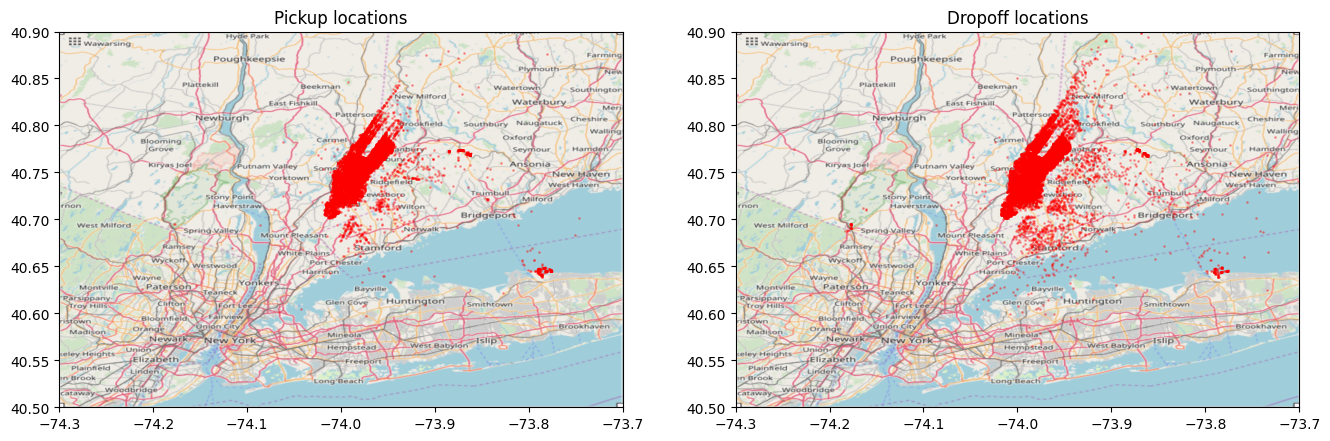

In [46]:
scatter_plot_on_map(sample_df,Bounding_Box_Zoom,nyc_map,s=1,alpha=0.3)

Key와 Pickup_Datetime은 모두 날짜형식이지만, 날짜 및 시분초 모두 같은 것을 확인할 수 있음
- Pickup_Datetime만을 사용함

In [47]:
sample_df['Year']=sample_df['pickup_datetime'].dt.year
sample_df['Month']=sample_df['pickup_datetime'].dt.month
sample_df['Date']=sample_df['pickup_datetime'].dt.day
sample_df['Day of Week']=sample_df['pickup_datetime'].dt.dayofweek
sample_df['Hour']=sample_df['pickup_datetime'].dt.hour
print(sample_df.iloc[:,8:])

          Year  Month  Date  Day of Week  Hour
13585037  2014      1    25            5    16
11400151  2015      6    30            1    13
11073453  2014      6    27            4    22
8266036   2013     12    12            3    21
42664     2015      1    14            2    11
...        ...    ...   ...          ...   ...
12538416  2012      3    16            4    20
9310708   2012     10    16            1    19
12218000  2014      5    27            1    13
6983390   2015      1    16            4     8
6168861   2013      4     1            0    12

[13499 rows x 5 columns]


Day of Week 값이 숫자로 나옴
- 0은 Monday, Sunday=6으로 확인

각 날짜를 x출게 대입하여 그래프 확인

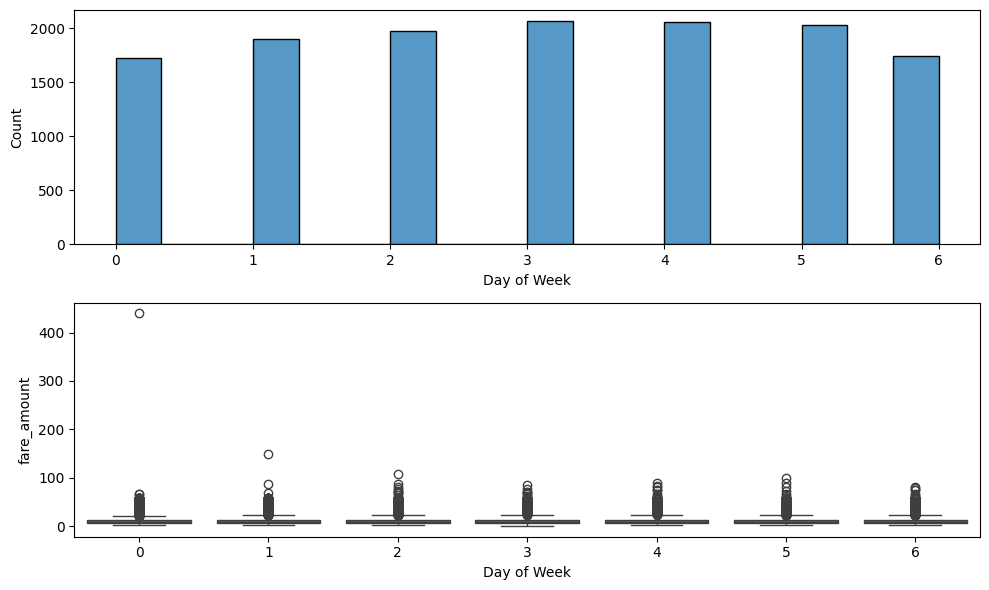

In [48]:
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,6))
sns.histplot(sample_df['Day of Week'],ax=ax[0])
ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Count')

sns.boxplot(x='Day of Week',y='fare_amount',data=sample_df,ax=ax[1])
ax[1].set_xlabel('Day of Week')

fig.tight_layout()
plt.show()

3,4,5의 값 목금토의 이용객 수가 많은 것을 확인할 수 있음

월요일, 화요일에 이상치가 눈에 띄는 것을 확인할 수 있음

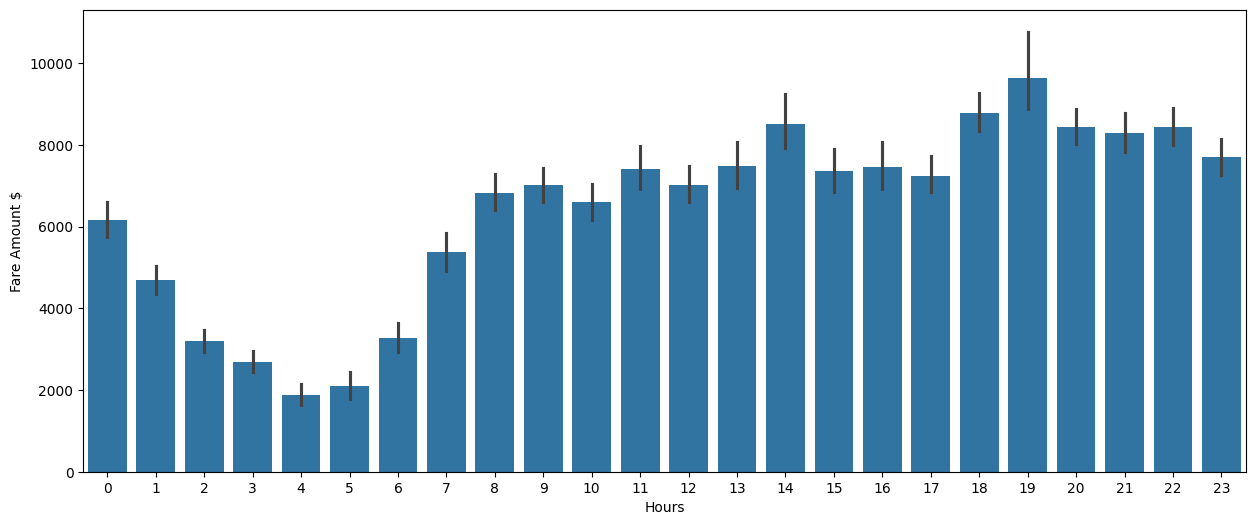

In [49]:
fig,ax=plt.subplots(figsize=(15,6))
sns.barplot(x='Hour',y='fare_amount',data=sample_df,estimator=sum)
ax.set_xlabel('Hours')
ax.set_ylabel('Fare Amount $')

plt.show()

estimator의 기본값은 mean인데 sum으로 바꾸면 언제 가장 요금이 많이 발생하는 지 알 수 있음
- 18시부터 22시의 합계가 가장 많은 것을 확인 할 수 있음
- 새벽 시간대는 상대적으로 적은 것을 확인 할 수 있음

## 피처 엔지니어링

In [50]:
def skip_logic(index,skip_num):
  if index%skip_num==0:
    return False
  return True

train=pd.read_csv('./train.csv',skiprows=lambda x:skip_logic(x,1000))
print(train.shape)
test=pd.read_csv('./test.csv')
submission=pd.read_csv('./sample_submission.csv')

(55423, 8)


In [51]:
print("Longitude Boundary in test")
print("Minimum Value of Longitude:",min(test.pickup_longitude.min(),test.dropoff_longitude.min()))
print("Maximum Value of Longitude:",max(test.pickup_longitude.max(),test.dropoff_longitude.max()))

Longitude Boundary in test
Minimum Value of Longitude: -74.263242
Maximum Value of Longitude: -72.986532


In [52]:
print("Latitude Boundary in test")
print("Minimum Value of Latitude:",min(test.pickup_latitude.min(),test.pickup_latitude.min()))
print("Maximum Value of Latitude:",max(test.pickup_latitude.max(),test.pickup_latitude.max()))

Latitude Boundary in test
Minimum Value of Latitude: 40.573143
Maximum Value of Latitude: 41.709555


In [53]:
def preprocessing(data):
  print("Old Shape Size:", data.shape)

  # Remove Missing Value
  data = data.drop(data[data.isnull().any(axis=1)].index, axis = 0)

  # Removing Outliers
  if 'fare_amount' in data.columns:
    data = data.drop(data[data['fare_amount'] < 0].index, axis=0).reset_index(drop=True)
    data = data.drop(data[data['fare_amount'] > 500].index, axis=0).reset_index(drop=True)

    # Removing Beyond NYC
    # 1 is beyond NY, so will delete
    boundary={'min_lng':-74.263242,'min_lat':40.573143,'max_lng':-72.986532, 'max_lat':41.709555}
    data.loc[~((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_beyond_NY']=1

    data.loc[((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_beyond_NY']=0
    print("Outlier vs Non Outlier Counts")
    print(data['is_beyond_NY'].value_counts())
    # print(data[data['is_beyond_NY'] == 1.0].head())
    data = data.drop(data[data['is_beyond_NY']== 1.0].index, axis=0).reset_index(drop=True)
    data.drop(['is_beyond_NY'], axis=1, inplace=True)

  data = data.drop(data[data['passenger_count'] > 6].index, axis=0).reset_index(drop=True)
  data = data.drop(data[data['passenger_count'] == 0].index, axis=0).reset_index(drop=True)
  data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

  # new variables from pickup_datetime
  data['year'] = data['pickup_datetime'].dt.year
  data['month'] = data['pickup_datetime'].dt.month
  data['date'] = data['pickup_datetime'].dt.day
  data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
  data['hour'] = data['pickup_datetime'].dt.hour

  # Delete Some Variables
  data.drop(['key','pickup_datetime'], axis=1, inplace=True)

  print("New Shape Size:", data.shape)
  return data

In [54]:
new_train = preprocessing(train)
new_train

Old Shape Size: (55423, 8)
Outlier vs Non Outlier Counts
is_beyond_NY
0.0    54190
1.0     1230
Name: count, dtype: int64
New Shape Size: (53997, 11)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,day_of_week,hour
0,10.9,-73.988455,40.758432,-73.983816,40.730147,1,2012,5,18,4,18
1,7.5,-73.991776,40.726189,-73.987656,40.739204,5,2015,2,1,6,2
2,56.8,-73.988152,40.740112,-73.782355,40.646727,2,2012,10,23,1,7
3,14.5,-73.984455,40.759038,-74.011728,40.707793,2,2010,7,31,5,22
4,13.3,-73.983301,40.743722,-73.964523,40.710758,1,2011,2,28,0,18
...,...,...,...,...,...,...,...,...,...,...,...
53992,10.5,-73.984875,40.729762,-74.001793,40.746700,1,2013,2,3,6,22
53993,17.5,-73.984185,40.749052,-73.911797,40.761047,1,2012,12,22,5,3
53994,8.5,-73.971578,40.755180,-73.978423,40.751367,1,2013,10,14,0,8
53995,14.9,-73.999957,40.678620,-74.007187,40.728660,1,2009,8,5,2,7


### 하버사인
일반적으로 위도와 경도를 구할 때는 하버사인 공식을 활용한다

In [55]:
!pip install haversine

In [56]:
#예제
#서울과 부산의 직선거리
from haversine import haversine, Unit
seoul=(37.532600, 127.024512)
busan=(35.114839, 129.041494)

haversine(seoul,busan)

323.9047477327599

In [58]:
distances=[]
pick_lon=new_train['pickup_longitude'].tolist()
pick_lat=new_train['pickup_latitude'].tolist()
drop_lon=new_train['dropoff_longitude'].tolist()
drop_lat=new_train['dropoff_latitude'].tolist()

for row in range(len(new_train)):
  dist=haversine((pick_lat[row],pick_lon[row]),(drop_lat[row],drop_lon[row]))
  distances.append(dist)

new_train['distances']=distances
print(new_train[['fare_amount','distances','passenger_count']])

       fare_amount  distances  passenger_count
0             10.9   3.169341                1
1              7.5   1.488336                5
2             56.8  20.220492                2
3             14.5   6.144112                2
4             13.3   3.992399                1
...            ...        ...              ...
53992         10.5   2.361989                1
53993         17.5   6.241498                1
53994          8.5   0.715686                1
53995         14.9   5.597480                1
53996          8.0   1.118084                1

[53997 rows x 3 columns]


이는 도로의 거리가 아닌 직선거리이기에 정확하지 않을 수 있음
- 좌표간 거리를 구했기에 위도와 경도 등은 모두 삭제

In [59]:
new_train.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53997 entries, 0 to 53996
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fare_amount      53997 non-null  float64
 1   passenger_count  53997 non-null  int64  
 2   year             53997 non-null  int32  
 3   month            53997 non-null  int32  
 4   date             53997 non-null  int32  
 5   day_of_week      53997 non-null  int32  
 6   hour             53997 non-null  int32  
 7   distances        53997 non-null  float64
dtypes: float64(2), int32(5), int64(1)
memory usage: 2.3 MB


## Modeling

Training+Validation+Test 데이터로 분할

(캐글에서는 Test를 별도로 제공하는 경우가 많아 Train+Validation으로 분할함)

### 하이퍼 파라미터 튜닝
입문자의 경우 모델을 어설프게 튜닝할 가능성이 높아 하이퍼 파라미터 튜닝을 하기보단 모형이 기본적으로 제공하는 파라미터에서 모델을 개발하는 것이 경제적임

모형의 성능이 좋다, 나쁘다의 기준 중 하나는 검증 데이터이다
- 모든 결과값을 검증 데이터에 맞출 경우 과적합이 일어날 수 있음

In [60]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from math import sqrt
import time
import datetime

y=new_train['fare_amount']
new_train.drop(['fare_amount'],axis=1,inplace=True)
X=new_train
X.shape,y.shape

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


((53997, 7), (53997,))

In [61]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=123)
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((43197, 7), (10800, 7), (43197,), (10800,))

In [62]:
#XGBoost
params={'max_depth':5,
        'learning_rate':0.5,

        'objective':'reg:linear',
        'eval_metic':'rmse',
        'early_stopping_rounds':5
      }

xgb_model=xgb.XGBRegressor(**params)
print(xgb_model)

start=time.time()
xgb_model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose=True)

sec=time.time()-start
times=str(datetime.timedelta(seconds=sec)).split(".")
times=times[0]
print(times)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metic='rmse', eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
[0]	validation_0-rmse:6.14504


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:19:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:19:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "eval_metic" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-rmse:4.83197
[2]	validation_0-rmse:4.40892
[3]	validation_0-rmse:4.27566
[4]	validation_0-rmse:4.23879
[5]	validation_0-rmse:4.25576
[6]	validation_0-rmse:4.25218
[7]	validation_0-rmse:4.25391
[8]	validation_0-rmse:4.27320
0:00:01


In [63]:
new_test=preprocessing(test)

distances=[]
pick_lon=new_test['pickup_longitude'].tolist()
pick_lat=new_test['pickup_latitude'].tolist()
drop_lan=new_test['dropoff_longitude'].tolist()
drop_lat=new_test['dropoff_latitude'].tolist()

for row in range(len(new_test)):
  dist=haversine((pick_lat[row],pick_lon[row]),(drop_lat[row],drop_lon[row]))
  distances.append(dist)

new_test['distances']=distances
new_test.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

Old Shape Size: (9914, 7)
New Shape Size: (9914, 10)


In [64]:
y_pred_xgb=xgb_model.predict(new_test)
print(y_pred_xgb)

[10.120141  9.754778 37.57076  ... 28.590029 20.277637 14.240971]


In [65]:
submission['fare_amount']=y_pred_xgb
submission.to_csv('final_submission.csv',index=False)

In [68]:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f final_submission.csv -m "Message"

100% 370k/370k [00:00<00:00, 605kB/s]
Successfully submitted to New York City Taxi Fare Prediction